In [1]:
import numpy as np
import pandas as pd
import scanpy as sc
%matplotlib inline
import matplotlib.pyplot as plt

import sys 
import inspect
import seaborn as sns
import os

import perturbseq as perturb

sc.settings.verbosity = 3  # verbosity: errors (0), warnings (1), info (2), hints (3)
sc.settings.set_figure_params(dpi=80, color_map='viridis')
sc.logging.print_versions()

scanpy==1.5.1 anndata==0.7.1 umap==0.4.4 numpy==1.17.2 scipy==1.4.1 pandas==0.24.2 scikit-learn==0.22 statsmodels==0.11.0 python-igraph==0.7.1 louvain==0.6.1 leidenalg==0.8.1


In [2]:
DATA='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14'
FIGS=DATA+'/2020-09-15_Figures/'
os.system('mkdir -p '+FIGS)
print(FIGS)

sc.settings.figdir=FIGS


/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/2020-09-15_Figures/


Gene sizes
==

- extract principal transcript from APPRIS
- if multiple, take max length

In [3]:
#read list of cancer genes
cancer_f='/ahg/regevdata/projects/bn10_cancer_variants/bn10_oana_2018-06-22/results/2018-06-22/results/2020-02-14/data/foundation_genes.txt'
cancer_genes=list(pd.read_csv(cancer_f,header=None).loc[:,0])
print(cancer_genes)
print(len(cancer_genes))

#assign each gene to a principal transcript
appris_f='/ahg/regevdata/projects/Cell2CellCommunication/data/genomes/hg38/translated/appris_data.principal.txt'

gene_transcripts={}
for line in open(appris_f,'r').readlines():
    items=line.strip().split('\t')
    if 'PRINCIPAL' in items[4]:
        gene=items[0]
        transcript=items[2]
        if gene not in gene_transcripts:
            gene_transcripts[gene]=[]
        gene_transcripts[gene].append(transcript)
        
print(len(list(set(gene_transcripts.keys()).intersection(set(cancer_genes)))))
print('missed',list(set(cancer_genes).difference(set(gene_transcripts.keys()))))

['ABL1', 'ACVR1B', 'AKT1', 'AKT2', 'AKT3', 'ALK', 'ALOX12B', 'AMER1', 'FAM123B', 'APC', 'AR', 'ARAF', 'ARFRP1', 'ARID1A', 'ASXL1', 'ATM', 'ATR', 'ATRX', 'AURKA', 'AURKB', 'AXIN1', 'AXL', 'BAP1', 'BARD1', 'BCL2', 'BCL2L1', 'BCL2L2', 'BCL6', 'BCOR', 'BCORL1', 'BRAF', 'BRCA1', 'BRCA2', 'BRD4', 'BRIP1', 'BTG1', 'BTG2', 'BTK', 'C11orf30', 'EMSY', 'CALR', 'CARD11', 'CASP8', 'CBFB', 'CBL', 'CCND1', 'CCND2', 'CCND3', 'CCNE1', 'CD22', 'CD274', 'PD-L1', 'CD70', 'CD79A', 'CD79B', 'CDC73', 'CDH1', 'CDK12', 'CDK4', 'CDK6', 'CDK8', 'CDKN1A', 'CDKN1B', 'CDKN2A', 'CDKN2B', 'CDKN2C', 'CEBPA', 'CHEK1', 'CHEK2', 'CIC', 'CREBBP', 'CRKL', 'CSF1R', 'CSF3R', 'CTCF', 'CTNNA1', 'CTNNB1', 'CUL3', 'CUL4A', 'CXCR4', 'CYP17A1', 'DAXX', 'DDR1', 'DDR2', 'DIS3', 'DNMT3A', 'DOT1L', 'EED', 'EGFR', 'EP300', 'EPHA3', 'EPHB1', 'EPHB4', 'ERBB2', 'ERBB3', 'ERBB4', 'ERCC4', 'ERG', 'ERRFI1', 'ESR1', 'EZH2', 'FAM46C', 'FANCA', 'FANCC', 'FANCG', 'FANCL', 'FAS', 'FBXW7', 'FGF10', 'FGF12', 'FGF14', 'FGF19', 'FGF23', 'FGF3', 'FGF4

In [4]:
#we'll need to manually figure out the gene symbols for these
d={}
d['FAM123B']='AMER1'
d['WHSC1']='NSD2'
d['H3F3A']='H3-3A'
d['FAM46C']='TENT5C'
d['MLL']='KMT2A'
d['C17orf39']='GID4'
d['PD-L2']='PDCD1LG2'
d['C11orf30']='EMSY'
d['MEK1']='MAP2K1'
d['MYCL1']='MYCL'
d['PD-1']='PDCD1'
d['PD-L1']='CD274'
d['MLL2']='KMT2D'
d['MMSET']='NSD2'
d['WHSC1L1']='NSD3'
d['MRE11A']='MRE11'
d['PARK2']='PRKN'
d['MEK2']='MAP2K2'
for gene in list(set(gene_transcripts.keys()).intersection(set(cancer_genes))):
    d[gene]=gene
print(d)

remapped=[]
for gene in d:
    remapped.append(d[gene])
print(len(remapped))

{'FAM123B': 'AMER1', 'WHSC1': 'NSD2', 'H3F3A': 'H3-3A', 'FAM46C': 'TENT5C', 'MLL': 'KMT2A', 'C17orf39': 'GID4', 'PD-L2': 'PDCD1LG2', 'C11orf30': 'EMSY', 'MEK1': 'MAP2K1', 'MYCL1': 'MYCL', 'PD-1': 'PDCD1', 'PD-L1': 'CD274', 'MLL2': 'KMT2D', 'MMSET': 'NSD2', 'WHSC1L1': 'NSD3', 'MRE11A': 'MRE11', 'PARK2': 'PRKN', 'MEK2': 'MAP2K2', 'CHEK1': 'CHEK1', 'NTRK2': 'NTRK2', 'PAX5': 'PAX5', 'SMO': 'SMO', 'CDKN2C': 'CDKN2C', 'BRCA2': 'BRCA2', 'SDHA': 'SDHA', 'BCL2': 'BCL2', 'ARAF': 'ARAF', 'FH': 'FH', 'PTPN11': 'PTPN11', 'ATRX': 'ATRX', 'BCOR': 'BCOR', 'KMT2A': 'KMT2A', 'AKT1': 'AKT1', 'AKT3': 'AKT3', 'RAF1': 'RAF1', 'CRKL': 'CRKL', 'HGF': 'HGF', 'JAK2': 'JAK2', 'JUN': 'JUN', 'SMARCA4': 'SMARCA4', 'NTRK3': 'NTRK3', 'PPP2R1A': 'PPP2R1A', 'NFE2L2': 'NFE2L2', 'IKBKE': 'IKBKE', 'CSF3R': 'CSF3R', 'CSF1R': 'CSF1R', 'EMSY': 'EMSY', 'TYRO3': 'TYRO3', 'CD79A': 'CD79A', 'CHEK2': 'CHEK2', 'IKZF1': 'IKZF1', 'QKI': 'QKI', 'ERRFI1': 'ERRFI1', 'FGFR1': 'FGFR1', 'MEF2B': 'MEF2B', 'HDAC1': 'HDAC1', 'CDK4': 'CDK4', 

In [5]:
#read in gene sizes by gene symbol
import gzip

gene_sizes={}
f_translation='/ahg/regevdata/projects/Cell2CellCommunication/data/genomes/hg38/translated/gencode.v34.pc_translations.fa.gz'
for line in gzip.open(f_translation,'rb').readlines():
    items=line.decode().strip().split('|')
    for gene in remapped:
        skip=True
        if gene in items and '>' in items[0]:
            #print(items)
            if gene in gene_transcripts:
                for transcript in gene_transcripts[gene]:
                    if transcript in line.decode():
                        skip=False
            if not skip:
                gene_size=items[-1]
                if gene not in gene_sizes:
                    gene_sizes[gene]=[]
                gene_sizes[gene].append(int(gene_size))

In [6]:
print(len(remapped))
print(len(set(remapped)))

321
309


In [7]:
print('genes repeated in the list')
for gene in set(remapped):
    counted=remapped.count(gene)
    if counted>1:
        print(gene,counted)
            
        for gene2 in d:
            if d[gene2]==gene:
                print(gene,gene2)
        print('===')

genes repeated in the list
KMT2A 2
KMT2A MLL
KMT2A KMT2A
===
EMSY 2
EMSY C11orf30
EMSY EMSY
===
KMT2D 2
KMT2D MLL2
KMT2D KMT2D
===
AMER1 2
AMER1 FAM123B
AMER1 AMER1
===
CD274 2
CD274 PD-L1
CD274 CD274
===
NSD2 2
NSD2 WHSC1
NSD2 MMSET
===
PDCD1LG2 2
PDCD1LG2 PD-L2
PDCD1LG2 PDCD1LG2
===
PDCD1 2
PDCD1 PD-1
PDCD1 PDCD1
===
GID4 2
GID4 C17orf39
GID4 GID4
===
MAP2K1 2
MAP2K1 MEK1
MAP2K1 MAP2K1
===
MYCL 2
MYCL MYCL1
MYCL MYCL
===
MAP2K2 2
MAP2K2 MEK2
MAP2K2 MAP2K2
===


In [8]:
print(len(gene_sizes.keys()))

309


In [9]:
gene_size_df=pd.DataFrame(columns=['gene','size'])
for gene in gene_sizes:
    gene_size_df_here=pd.DataFrame({'gene':gene,
                                   'size':list(set(gene_sizes[gene]))})
    gene_size_df=pd.concat([gene_size_df,gene_size_df_here])

In [10]:
gene_size_df[gene_size_df['gene']=='EGFR']

,gene,size
0,EGFR,1210


In [11]:
os.system('mkdir -p '+DATA+'/anno/')
gene_size_df.to_csv(DATA+'/anno/'+'gene_sizes.csv')

In [12]:
gene_size_df=pd.read_csv(DATA+'/anno/'+'gene_sizes.csv').iloc[:,1:]
print(gene_size_df.shape)
print(gene_size_df)

(309, 2)
         gene  size
0    TNFRSF14   283
1      ERRFI1   462
2        MTOR  2549
3        SPEN  3664
4        SDHB   280
5         ID3   119
6      ARID1A  2285
7       HDAC1   482
8       CSF3R   863
9        MYCL   364
10        MPL   635
11      MUTYH   546
12     RAD54L   747
13      MKNK1   412
14     CDKN2C   168
15        JUN   331
16       JAK1  1154
17      FUBP1   644
18       NRAS   189
19     TENT5C   391
20     HSD3B1   373
21     NOTCH2  2471
22       MCL1   350
23      NTRK1   796
24       SDHC   169
25       DDR2   855
26      CDC73   531
27       BTG2   158
28    PIK3C2B  1634
29       MDM4   490
..        ...   ...
279     POLD1  1107
280   PPP2R1A   589
281    BCL2L1   233
282     ASXL1  1541
283       SRC   536
284    ZNF217  1048
285     AURKA   403
286      GNAS   394
287    ARFRP1   201
288       ERG   479
289     U2AF1   240
290      CRKL   303
291     MAPK1   360
292   SMARCB1   385
293     CHEK2   543
294       NF2   595
295     EP300  2414
296     P2R

In [13]:
#for now, let's take the max transcript
import copy
max_sizes=gene_size_df.groupby('gene').max()
max_sizes=max_sizes*3
max_sizes_clipped=copy.deepcopy(max_sizes)
max_sizes_clipped[max_sizes_clipped>5000]=5000

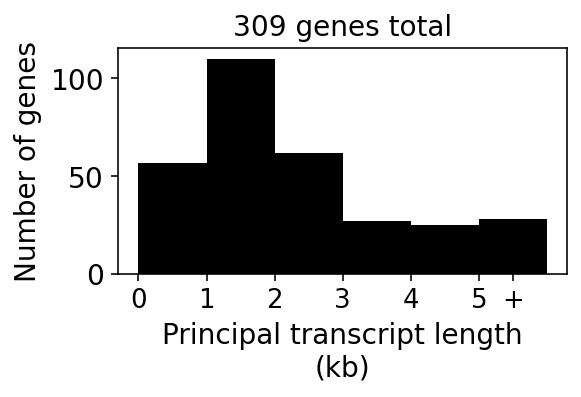

In [14]:
fig,plots=plt.subplots(1)
fig.set_size_inches(4,2)

plots.hist(list(max_sizes_clipped['size']/1000),range(7),color='black')
plots.set_xlabel('Principal transcript length\n(kb)')
plots.set_ylabel('Number of genes')
plots.set_title(str(max_sizes_clipped.shape[0])+' genes total')
plots.set_xticks([0,1,2,3,4,5,5.5])
plots.set_xticklabels([0,1,2,3,4,5,'+'],fontsize=13)
plots.grid(False)


plt.savefig(FIGS+'/transcriptLen.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/transcriptLen.png',bbox_inches = "tight")
plt.show()

In [15]:
#computing the number of cells by size
def get_cells_accurate(max_sizes_clipped,transcript_length=999,cells_per_variant=10):
    of_interest=max_sizes_clipped.loc[max_sizes_clipped['size']<=transcript_length]
    codons=of_interest['size'].sum()/3
    amino_acids=20
    print('num variants (M)')
    print(codons*amino_acids/1000000)
    num_cells=codons*amino_acids*cells_per_variant
    #account for a 65% singlet rate
    num_cells=int(num_cells*1/0.65)
    print('length<',transcript_length,'bp | cells per variant',
          cells_per_variant,'| required total cells (M):',num_cells/1000000)
    
get_cells_accurate(max_sizes_clipped,
          transcript_length=999,cells_per_variant=10)
get_cells_accurate(max_sizes_clipped,
          transcript_length=1998,cells_per_variant=10)
get_cells_accurate(max_sizes_clipped,
          transcript_length=3000,cells_per_variant=10)

num variants (M)
0.27004
length< 999 bp | cells per variant 10 | required total cells (M): 4.154461
num variants (M)
1.3293
length< 1998 bp | cells per variant 10 | required total cells (M): 20.450769
num variants (M)
2.37022
length< 3000 bp | cells per variant 10 | required total cells (M): 36.464923


In [16]:
def compute_cost(num_cells,hashing=False):
    cost=0.55 
    #$0.33/cell for 10x 3', v3
    #plus $0.22/cell sequencing ($1750 per hiseq for 2 channels per hiseq, with 4000 cells/channel)
    
    if hashing:
        cost=0.21
        #13k cells/channel and 2 hiseqs, would be:
        #10x: 1250/13000=0.09
        #and sequencing: 1750/13000=0.13
        #=> $0.21/cell
        
    print('cells (M):',num_cells/1000000,'cost (M):',num_cells*cost/1000000)
  

In [17]:
#now compute with the actual lengths of the genes
m=1000000
compute_cost(4.1*m,hashing=True)
compute_cost(4.1*m,hashing=False)

m=1000000
compute_cost(36*m,hashing=True)
compute_cost(36*m,hashing=False)

cells (M): 4.1 cost (M): 0.8609999999999999
cells (M): 4.1 cost (M): 2.255
cells (M): 36.0 cost (M): 7.56
cells (M): 36.0 cost (M): 19.8


Power analysis
==

In [18]:
def read_in_scores(fname,PROTEIN,anno):
    scores=pd.read_csv(fname)
    scores['protein']=PROTEIN
    scores.index=scores['group2']
    scores['cluster_color']=anno.loc[scores.index,'cluster_color']
    scores['log10_HotellingT2']=np.log10(scores['HotellingT2'])
    scores['FDR.log10_HotellingT2']=scores['FDR.HotellingT2']
    scores['text_color']=anno.loc[scores.index,'text_color']
    scores['control_color']=anno.loc[scores.index,'control_color']
    scores['syn_unknown_hotspot']=anno.loc[scores.index,'control_status']
    scores.loc[scores['syn_unknown_hotspot']=='synonymous','syn_unknown_hotspot']
    scores['control_color2']=scores['control_color']
    colo='blue'
    if PROTEIN=='KRAS':
        colo='red'
    scores.loc[scores['control_color2']=='white','control_color2']=colo
    return(scores)

In [19]:
PROTEIN='TP53'

#anno====================
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno_tp53=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.withresults.csv',sep='\t',index_col=0)

#scores =================
ref='P359P'
p53_scorefile=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN+'.scores_vs_'+ref+'.csv'
total_scores_tp53=read_in_scores(p53_scorefile,'TP53',anno_tp53)



/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [20]:
PROTEIN='KRAS'

#anno====================
FDR=0.01
#original anno
ANNO=DATA+'/'+PROTEIN+'/anno'
anno_kras=pd.read_csv(ANNO+'/'+PROTEIN+'.anno.withresults.csv',sep='\t',index_col=0)

#scores =================
ref='K169K'
kras_scorefile=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN+'.scores_vs_'+ref+'.csv'
total_scores_kras=read_in_scores(kras_scorefile,'KRAS',anno_kras)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in log10
  


In [21]:
total_scores_tp53.head()

,Unnamed: 0,HotellingT2,bulk.L1,bulk.pearson,bulk.spearman,group1,group2,FDR.bulk.L1,FDR.HotellingT2,FDR.bulk.spearman,FDR.bulk.pearson,control_status2,protein,cluster_color,log10_HotellingT2,FDR.log10_HotellingT2,text_color,control_color,syn_unknown_hotspot,control_color2
group2,,,,,,,,,,,,,,,,,,,,
C275F,0,412.805303,0.072604,1.610414,1.532150,P359P,C275F,0.004,0.004,0.004,0.004,unknown,TP53,navy,2.615745,0.004,black,white,unknown,blue
H193L,1,394.517194,0.071285,1.596694,1.523259,P359P,H193L,0.004,0.004,0.004,0.004,unknown,TP53,navy,2.596066,0.004,black,white,unknown,blue
P278S,2,422.103560,0.069585,1.574789,1.488470,P359P,P278S,0.004,0.004,0.004,0.004,unknown,TP53,navy,2.625419,0.004,black,white,unknown,blue
P151S,3,382.020615,0.072390,1.570358,1.477232,P359P,P151S,0.004,0.004,0.004,0.004,unknown,TP53,navy,2.582087,0.004,black,white,unknown,blue
I195T,4,336.572988,0.067824,1.560756,1.488158,P359P,I195T,0.004,0.004,0.004,0.004,unknown,TP53,navy,2.527079,0.004,black,white,unknown,blue


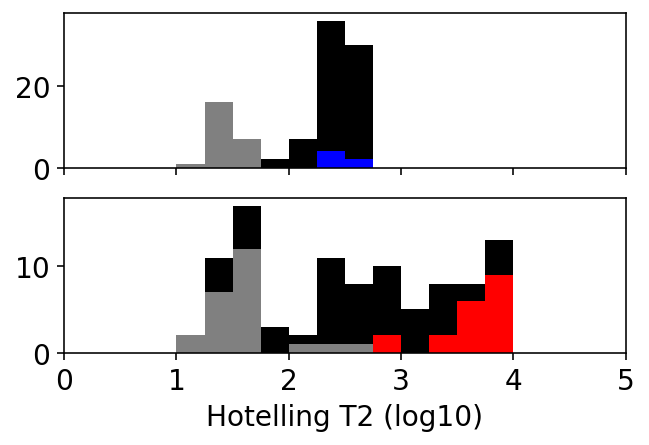

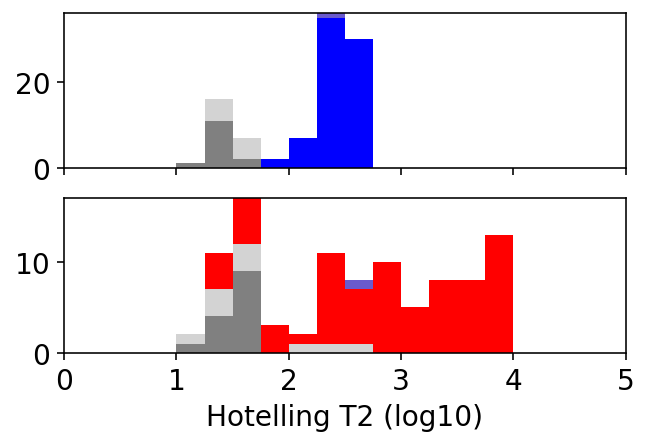

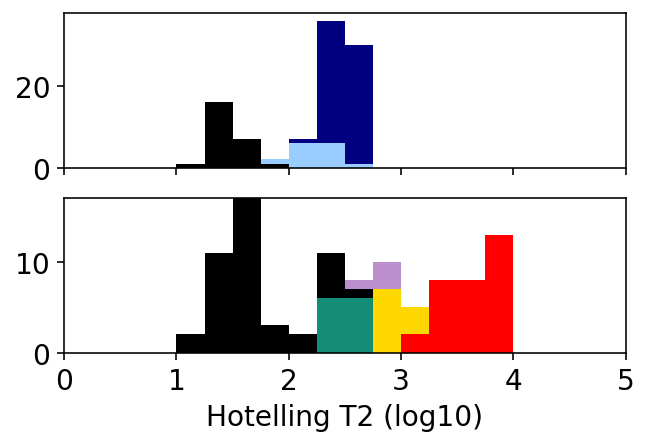

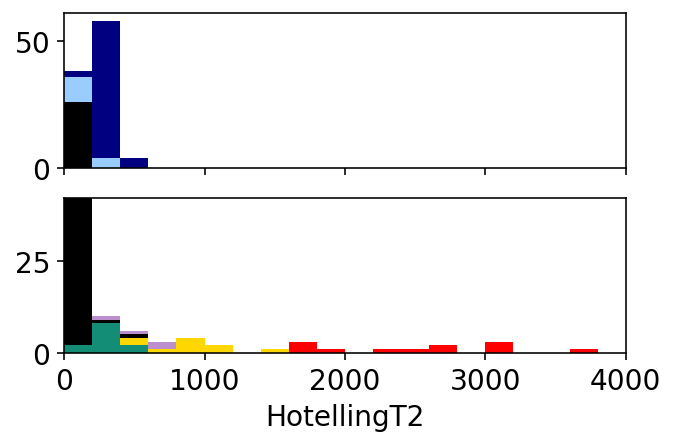

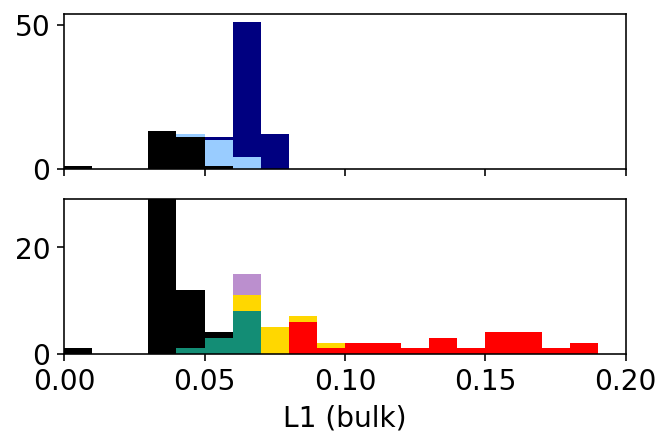

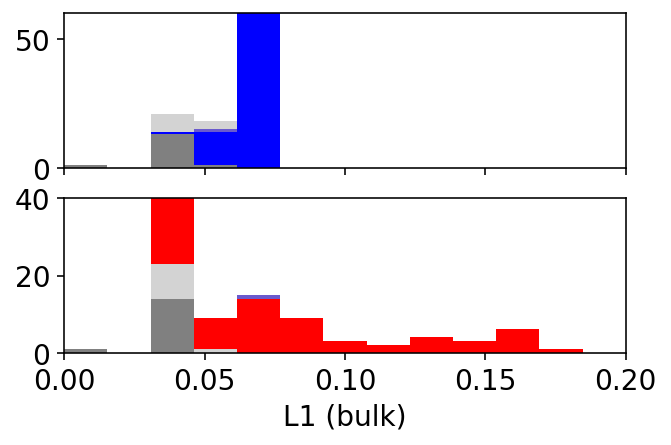

In [22]:
def plot_score_hist(total_scores_p53,
                   total_scores_kras,
                   method,colorname='cluster_color',
                   minbin=0,maxbin=5,num_bins=20,
                   scorename=''):
    
    #define the bins
    binsize=((maxbin-minbin)/num_bins)
    mybins=[x*binsize+minbin for x in range(num_bins)]
    
    fig,plots=plt.subplots(2,1)
    fig.set_size_inches(5,3)
    
    #TP53
    color_options=list(set(total_scores_p53[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_p53.loc[total_scores_p53[colorname]==color,method])
    a=plots[0].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    plots[0].set_xticklabels([])
    
    #KRAS
    color_options=list(set(total_scores_kras[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_kras.loc[total_scores_kras[colorname]==color,method])
    a=plots[1].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    plots[1].set_xlabel(scorename)
    
    for p_idx in range(2):
        plots[p_idx].grid(False)
        plots[p_idx].set_xlim(minbin,maxbin)

plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='log10_HotellingT2',colorname='text_color',
                   minbin=0,maxbin=5,num_bins=20,scorename='Hotelling T2 (log10)')
        
plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='log10_HotellingT2',colorname='control_color2',
                   minbin=0,maxbin=5,num_bins=20,scorename='Hotelling T2 (log10)')

plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='log10_HotellingT2',colorname='cluster_color',
                   minbin=0,maxbin=5,num_bins=20,scorename='Hotelling T2 (log10)')
plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='HotellingT2',colorname='cluster_color',
                   minbin=0,maxbin=4000,num_bins=20,scorename='HotellingT2')

plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='bulk.L1',colorname='cluster_color',
                   minbin=0,maxbin=0.2,num_bins=20,scorename='L1 (bulk)')

plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='bulk.L1',colorname='control_color2',
                   minbin=0,maxbin=0.2,num_bins=13,scorename='L1 (bulk)')

[0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]


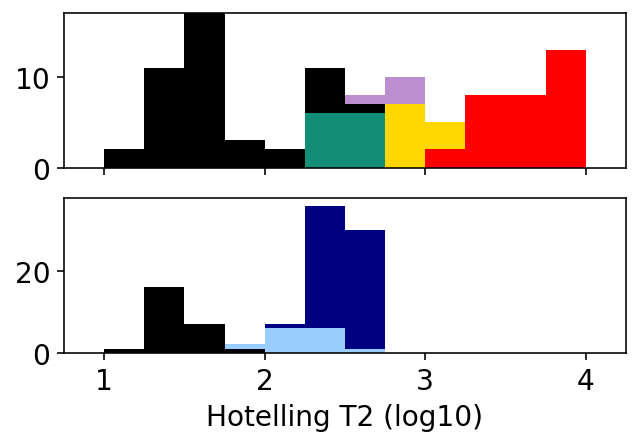

In [23]:
def plot_score_hist(total_scores_p53,
                   total_scores_kras,
                   method,colorname='cluster_color',
                   minbin=0,maxbin=5,num_bins=20,
                   scorename=''):
    
    #define the bins
    binsize=((maxbin-minbin)/num_bins)
    mybins=[x*binsize+minbin for x in range(num_bins)]
    print(mybins)
    
    fig,plots=plt.subplots(2,1)
    fig.set_size_inches(5,3)
    
    #TP53
    color_options=list(set(total_scores_p53[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_p53.loc[total_scores_p53[colorname]==color,method])
    a=plots[1].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    
    
    #KRAS
    color_options=list(set(total_scores_kras[colorname]))
    scorelist=[]
    for i in range(len(color_options)):
        color=color_options[i]
        scorelist.append(total_scores_kras.loc[total_scores_kras[colorname]==color,method])
    a=plots[0].hist(scorelist,histtype='bar', stacked=True,color=color_options,bins=mybins)
    plots[1].set_xlabel(scorename)
    plots[0].set_xticklabels([])
    
    for p_idx in range(2):
        plots[p_idx].grid(False)
        plots[p_idx].set_xlim(minbin,maxbin)


plot_score_hist(total_scores_tp53,
                   total_scores_kras,
                   method='log10_HotellingT2',colorname='cluster_color',
                   minbin=0.75,maxbin=4.25,num_bins=14,scorename='Hotelling T2 (log10)')

plt.savefig(FIGS+'/hist_scores.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/hist_scores.png',bbox_inches = "tight")

In [24]:
total_scores_p53=total_scores_tp53

In [25]:
mybins=[0.75, 1.0, 1.25, 1.5, 1.75, 2.0, 2.25, 2.5, 2.75, 3.0, 3.25, 3.5, 3.75, 4.0]

In [26]:
binsize=0.25
#put the variants into bins here
method='log10_HotellingT2'
true_scores=pd.concat([total_scores_p53,total_scores_kras])
true_scores.index=true_scores['protein']+true_scores['group2']
true_scores['bin']=-1
#true_scores['FDR.log10_HotellingT2']=true_scores['FDR.HotellingT2']

for mybin_idx in range(len(mybins)):
    mybin=mybins[mybin_idx]
    mybin_min=mybins[mybin_idx]
    mybin_max=mybins[mybin_idx]+binsize
    vars_here=[]
    for variant in list(true_scores.index):
        val=float(true_scores.loc[variant,method])
        if val>=mybin_min and val<mybin_max:
            vars_here.append(variant)
    true_scores.loc[vars_here,'bin']=mybin
print(true_scores.sort_values(by='bin').tail())

           Unnamed: 0  HotellingT2   bulk.L1  bulk.pearson  bulk.spearman  \
KRASG13E           10  7817.908651  0.194548      1.800549       1.711654   
KRASA146P          13  5931.447865  0.152907      1.757684       1.622636   
KRASA146T          15  6988.005702  0.153495      1.748189       1.640087   
KRASG13R            1  8724.141823  0.199745      1.827538       1.742500   
KRASG12D            0  6675.185293  0.194790      1.829270       1.739853   

          group1 group2  FDR.bulk.L1  FDR.HotellingT2  FDR.bulk.spearman  ...  \
KRASG13E   K169K   G13E     0.004016         0.004016           0.004016  ...   
KRASA146P  K169K  A146P     0.004016         0.004016           0.004016  ...   
KRASA146T  K169K  A146T     0.004016         0.004016           0.004016  ...   
KRASG13R   K169K   G13R     0.004016         0.004016           0.004016  ...   
KRASG12D   K169K   G12D     0.004016         0.004016           0.004016  ...   

           control_status2 protein cluster_color l

In [27]:
counts=20000

In [28]:
results=pd.DataFrame(columns=['method','subsampled_cells_per_variant','counts','effect_size_bin','auPRC','correct'])

SUBSAMPLING_LIST=[1000,900,800,700,600,500,400,300,200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10]
ITERATIONS=range(10)

methods=['log10_HotellingT2']
FDR=0.01

for method in methods:
    for subs_idx,subs in enumerate(SUBSAMPLING_LIST):
        scores_iter_list=[]
        for iter_idx,iter_name in enumerate(ITERATIONS):
            scores_here_protein={}
            for PROTEIN in ['TP53','KRAS']:
                
                OUT_PREF=DATA+'/'+PROTEIN+'/scoring/'+PROTEIN
                out_here=OUT_PREF+'.cellsPerVar'+str(subs)+'.iter'+str(iter_name)+'.scores.gz'
                
                scores_here_protein[PROTEIN]=pd.read_csv(out_here,compression='gzip',sep='\t')
                scores_here_protein[PROTEIN]['protein']=PROTEIN
                scores_here_protein[PROTEIN].index=scores_here_protein[PROTEIN]['protein']+scores_here_protein[PROTEIN]['group2']
            scores_here_iter=pd.concat([scores_here_protein['TP53'],
                                       scores_here_protein['KRAS']],axis=0)
            scores_here_iter['log10_HotellingT2']=np.log10(scores_here_iter['HotellingT2'])
            scores_here_iter['FDR.log10_HotellingT2']=scores_here_iter['FDR.HotellingT2']
            #scores_here_iter=scores_here_protein['TP53']
            scores_iter_list.append(scores_here_iter)
        print(len(scores_iter_list))
        scores_subs=pd.concat(scores_iter_list,axis=0)
        print(subs,'scores subs',scores_subs.shape)
        
        for mybin_idx in range(len(mybins)):
            mybin=mybins[mybin_idx]
            mybin_min=mybins[mybin_idx]
            mybin_max=mybins[mybin_idx]+binsize
            
            #subselect only the variants in this bin
            #bin_variants=list(true_scores.loc[true_scores['bin']==mybin,:].index)
            scores_subs['bin']=true_scores.loc[scores_subs.index,'bin']
            scores_subs_inbin=np.array(1.0*(scores_subs['bin']==mybin))
            passed_fdr=np.array(1.0*(scores_subs['FDR.'+str(method)]<=FDR))
            correct=np.sum(np.multiply(scores_subs_inbin,passed_fdr))/np.sum(scores_subs_inbin)
            
            results_here=pd.DataFrame({'method':method,
                                       'subsampled_cells_per_variant':subs,
                                       'counts':counts,
                                       'effect_size_bin':int(1000*mybin)/1000,
                                       'auPRC':np.nan,
                                      'correct':correct},
                                      index=[method+str(subs)+str(mybin)])
            results=pd.concat([results,results_here],axis=0)
        
            

/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:25: RuntimeWarning: divide by zero encountered in log10


10
1000 scores subs (1990, 7)


/ahg/regevdata/users/oursu/software/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:43: RuntimeWarning: invalid value encountered in double_scalars


10
900 scores subs (1990, 7)
10
800 scores subs (1990, 7)
10
700 scores subs (1990, 7)
10
600 scores subs (1990, 7)
10
500 scores subs (1990, 7)
10
400 scores subs (1990, 7)
10
300 scores subs (1990, 7)
10
200 scores subs (1990, 7)
10
190 scores subs (1990, 7)
10
180 scores subs (1990, 7)
10
170 scores subs (1990, 7)
10
160 scores subs (1990, 7)
10
150 scores subs (1990, 7)
10
140 scores subs (1990, 7)
10
130 scores subs (1990, 7)
10
120 scores subs (1990, 7)
10
110 scores subs (1990, 7)
10
100 scores subs (1990, 7)
10
90 scores subs (1990, 7)
10
80 scores subs (1990, 7)
10
70 scores subs (1990, 7)
10
60 scores subs (1990, 7)
10
50 scores subs (1990, 7)
10
40 scores subs (1990, 7)
10
30 scores subs (1990, 7)
10
20 scores subs (1990, 7)
10
10 scores subs (1990, 7)


In [29]:
results['cells/variant']=results['subsampled_cells_per_variant']
results['sc-eVIP impact score']=results['effect_size_bin']
results2=results.pivot(index='sc-eVIP impact score',columns='cells/variant')['correct']
results2=results2.T
results2=results2.astype('float')
print(results2.head())

sc-eVIP impact score  0.75      1.00      1.25      1.50  1.75      2.00  \
cells/variant                                                              
10                     NaN  0.033333  0.003704  0.004167  0.00  0.011111   
20                     NaN  0.000000  0.003704  0.000000  0.00  0.022222   
30                     NaN  0.000000  0.007407  0.020833  0.02  0.122222   
40                     NaN  0.033333  0.011111  0.016667  0.02  0.077778   
50                     NaN  0.033333  0.018519  0.008333  0.06  0.077778   

sc-eVIP impact score      2.25      2.50  2.75  3.00    3.25    3.50  \
cells/variant                                                          
10                    0.014894  0.013158  0.05  0.16  0.3875  0.5000   
20                    0.065957  0.092105  0.18  0.42  0.7375  0.9375   
30                    0.144681  0.231579  0.69  0.86  0.9625  1.0000   
40                    0.142553  0.244737  0.73  0.98  1.0000  1.0000   
50                    0.257447  0.4

In [30]:
results2=results2.loc[:,[2.00,2.25,2.50,2.75,3.00,3.25,3.50,3.75]]

In [31]:
results_below200=results2.loc[[200,
                  190,180,170,160,150,140,130,120,110,100,90,80,70,60,50,40,30,20,10][::-1],:]
results_above200=results2.loc[[1000,900,800,700,600,500,400,300,200][::-1],:]

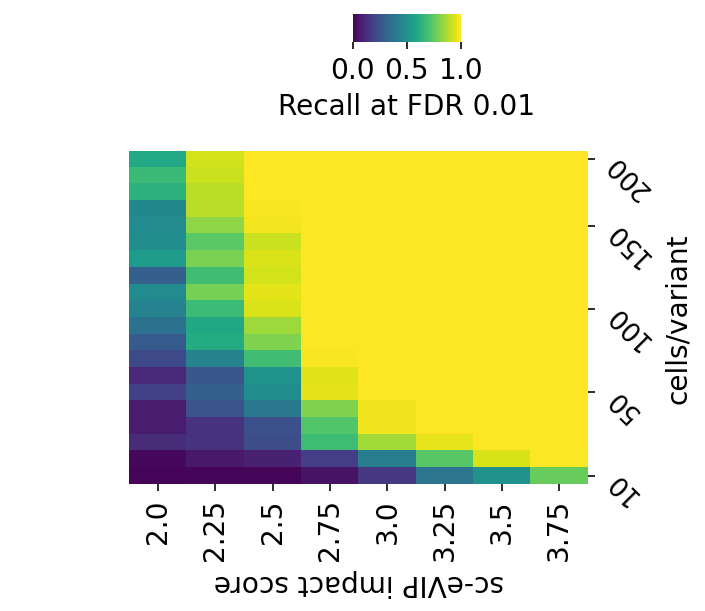

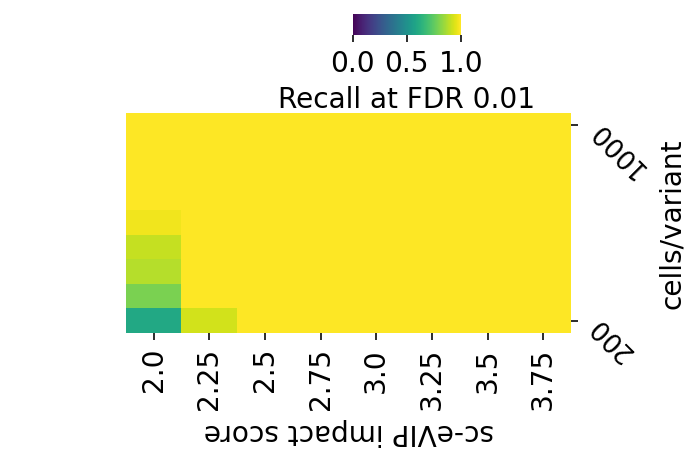

In [41]:
g=sns.clustermap(results_below200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,4),xticklabels=True,vmin=0,vmax=1,
                cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 cbar_kws={'orientation':'horizontal',
                "label": "Recall at FDR 0.01",
                'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,4.5,9.5,14.5,19.5])
g.ax_heatmap.set_yticklabels([200,150,100,50,10], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'PowerAnalysis_sensiFDR0.01.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.png',bbox_inches = "tight")
plt.show()

g=sns.clustermap(results_above200.iloc[::-1],cmap='viridis',col_cluster=False,row_cluster=False, #.T.iloc[:,::-1]
              yticklabels=True,figsize=(5,3),xticklabels=True,vmin=0,vmax=1,
                cbar_pos=(0.5, 1.0, 0.15, 0.05),
                 cbar_kws={'orientation':'horizontal',
                "label": "Recall at FDR 0.01",
                'ticks':[0,0.5,1]},)
g.ax_heatmap.set_yticks([0.5,8.5])
g.ax_heatmap.set_yticklabels([1000,200], fontsize = 13,rotation=135)
g.ax_heatmap.set_xlabel('sc-eVIP impact score',rotation=180)
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.part2.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_sensiFDR0.01.part2.png',bbox_inches = "tight")
plt.show()

In [34]:
results2.loc[500,:]

sc-eVIP impact score
2.00    0.911111
2.25    1.000000
2.50    1.000000
2.75    1.000000
3.00    1.000000
3.25    1.000000
3.50    1.000000
3.75    1.000000
Name: 500, dtype: float64

In [35]:
results2[np.isnan(results2)]=0
results2.columns=[str(x) for x in list(results2.columns)]
print(results2.columns)

Index(['2.0', '2.25', '2.5', '2.75', '3.0', '3.25', '3.5', '3.75'], dtype='object')


In [36]:
DESIRED_POWER=0.95

#for each effect size bin -> get the number of cells you need
cells_per_bin=pd.DataFrame({'effect size bin':results2.columns,
                            'cells_needed':1000},index=results2.columns)

#define bins of effect size
for score_type in ['log10_HotellingT2']:

    #get the bins
    for mybin_idx in range(len(mybins)):
        mybin=mybins[mybin_idx]
        bin_min=mybins[mybin_idx]
        bin_max=mybins[mybin_idx]+binsize
        if str(bin_min) not in list(results2.columns):
            continue
        
        for i in range(results2.shape[0]):
            cur_power=float(list(results2[str(bin_min)])[i])
            cur_cells=1000
            #print(i,cur_power)
            if cur_power>=DESIRED_POWER:
                cur_cells=results2.index[i]
                break
        cells_per_bin.loc[str(bin_min),'cells_needed']=cur_cells

In [37]:
cells_per_bin['effect size bin'].iloc[1:(len(cells_per_bin['effect size bin'])-1)]

2.25    2.25
2.5      2.5
2.75    2.75
3.0      3.0
3.25    3.25
3.5      3.5
Name: effect size bin, dtype: object

In [38]:
cells_per_bin['cells_needed']

2.0     600
2.25    300
2.5     120
2.75     60
3.0      40
3.25     30
3.5      30
3.75     20
Name: cells_needed, dtype: int64

In [42]:
cells_per_bin

,effect size bin,cells_needed
2.0,2.0,600
2.25,2.25,300
2.5,2.5,120
2.75,2.75,60
3.0,3.0,40
3.25,3.25,30
3.5,3.5,30
3.75,3.75,20


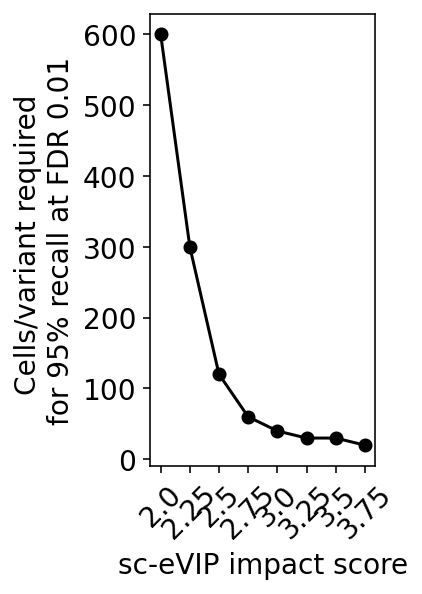

In [61]:
fig,plots=plt.subplots(1)
fig.set_size_inches(2,4)

plots.plot(cells_per_bin['effect size bin'],
           cells_per_bin['cells_needed'],
         color='black')
plots.scatter(cells_per_bin['effect size bin'],
           cells_per_bin['cells_needed'],
        color='black')
plots.set_ylabel('Cells/variant required \nfor 95% recall at FDR 0.01')
plots.set_xlabel('sc-eVIP impact score')
#plots.invert_yaxis()
#plots.set_yticks([0,100,200,300,400,500,600])
plots.grid(False)
plots.set_xticklabels(cells_per_bin['effect size bin'],
                      rotation=45)

plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded.png',bbox_inches = "tight")
plt.show()

In [85]:
#heatmap cells per number of variants
multipliers=[1,10,100,1000,10000,100000,1000000,10000000]

#heatmap cells per number of variants
multipliers=range(300,1000)
cells_per_bin_by_variant=pd.DataFrame(index=cells_per_bin['effect size bin'],
                                     columns=multipliers)
to_remove=[]
for m in multipliers:
    multiplier=np.power(10,m/150)
    if multiplier>50000000:
        to_remove.append(m)
        continue
    
    cells_per_bin_by_variant.loc[:,m]=multiplier*cells_per_bin['cells_needed']*1/0.65
    print(m,multiplier)

300 100.0
301 101.54689924330806
302 103.11772745930548
303 104.71285480508996
304 106.33265716371616
305 107.97751623277094
306 109.64781961431851
307 111.34396090623619
308 113.06633979496387
309 114.81536214968828
310 116.59144011798323
311 118.39499222293017
312 120.22644346174131
313 122.08622540590706
314 123.97477630289441
315 125.89254117941675
316 127.8399719463023
317 129.8175275049849
318 131.82567385564073
319 133.86488420699928
320 135.93563908785256
321 138.03842646028852
322 140.17374183467695
323 142.34208838643414
324 144.5439770745928
325 146.7799267622069
326 149.0504643386196
327 151.35612484362088
328 153.6974515935271
329 156.07499630921114
330 158.48931924611142
331 160.94098932625346
332 163.43058427231378
333 165.95869074375614
334 168.5259044750751
335 171.1328304161781
336 173.78008287493762
337 176.46828566194998
338 179.1980722375334
339 181.97008586099827
340 184.78497974222907
341 187.64341719560858
342 190.54607179632464
343 193.49362753909523
344 196.48

824 311410.5584446758
825 316227.7660168379
826 321119.4909364824
827 326086.88591189357
828 331131.1214825908
829 336253.3862951625
830 341454.88738336007
831 346736.85045253165
832 352100.5201684521
833 357547.1604506216
834 363078.05477010104
835 368694.50645195734
836 374397.83898238104
837 380189.39632056124
838 386070.5432153815
839 392042.6655270156
840 398107.1705534969
841 404265.4873623441
842 410519.0671273079
843 416869.3834703355
844 423317.9328088211
845 429866.2347082281
846 436515.8322401656
847 443268.29234600865
848 450125.20620613365
849 457088.1896148752
850 464158.8833612782
851 471338.95361574
852 478630.092322638
853 486034.0175990216
854 493552.4741394806
855 501187.2336272725
856 508940.0951518094
857 516812.885632603
858 524807.4602497723
859 532925.7028812002
860 541169.5265464637
861 549540.8738576248
862 558041.717476997
863 566674.0605819908
864 575439.9373371566
865 584341.4133735176
866 593380.5862753281
867 602559.5860743581
868 611880.5757518226
869 62

In [90]:
cells_per_bin_by_variant[955]

effect size bin
2.0     2.147359e+09
2.25    1.073679e+09
2.5     4.294717e+08
2.75    2.147359e+08
3.0     1.431572e+08
3.25    1.073679e+08
3.5     1.073679e+08
3.75    7.157862e+07
Name: 955, dtype: float64

In [91]:
#heatmap cells per number of variants
multipliers=[1,10,100,1000,10000,100000,1000000,270000,2300000,10000000]

#heatmap cells per number of variants
cells_per_bin_by_variant=pd.DataFrame(index=cells_per_bin['effect size bin'],
                                     columns=multipliers)
to_remove=[]
for m in multipliers:
    multiplier=m
    
    cells_per_bin_by_variant.loc[:,m]=multiplier*cells_per_bin['cells_needed']*1/0.65
    print(m,multiplier)

1 1
10 10
100 100
1000 1000
10000 10000
100000 100000
1000000 1000000
270000 270000
2300000 2300000
10000000 10000000


In [92]:
cells_per_bin_by_variant

,1,10,100,1000,10000,100000,1000000,270000,2300000,10000000
effect size bin,,,,,,,,,,
2.0,923.076923,9230.769231,92307.692308,923076.923077,9.230769e+06,9.230769e+07,9.230769e+08,2.492308e+08,2.123077e+09,9.230769e+09
2.25,461.538462,4615.384615,46153.846154,461538.461538,4.615385e+06,4.615385e+07,4.615385e+08,1.246154e+08,1.061538e+09,4.615385e+09
2.5,184.615385,1846.153846,18461.538462,184615.384615,1.846154e+06,1.846154e+07,1.846154e+08,4.984615e+07,4.246154e+08,1.846154e+09
2.75,92.307692,923.076923,9230.769231,92307.692308,9.230769e+05,9.230769e+06,9.230769e+07,2.492308e+07,2.123077e+08,9.230769e+08
3.0,61.538462,615.384615,6153.846154,61538.461538,6.153846e+05,6.153846e+06,6.153846e+07,1.661538e+07,1.415385e+08,6.153846e+08
3.25,46.153846,461.538462,4615.384615,46153.846154,4.615385e+05,4.615385e+06,4.615385e+07,1.246154e+07,1.061538e+08,4.615385e+08
3.5,46.153846,461.538462,4615.384615,46153.846154,4.615385e+05,4.615385e+06,4.615385e+07,1.246154e+07,1.061538e+08,4.615385e+08
3.75,30.769231,307.692308,3076.923077,30769.230769,3.076923e+05,3.076923e+06,3.076923e+07,8.307692e+06,7.076923e+07,3.076923e+08


In [70]:
df.index

Int64Index([1, 10, 100, 1000, 10000, 100000, 1000000, 10000000], dtype='int64')

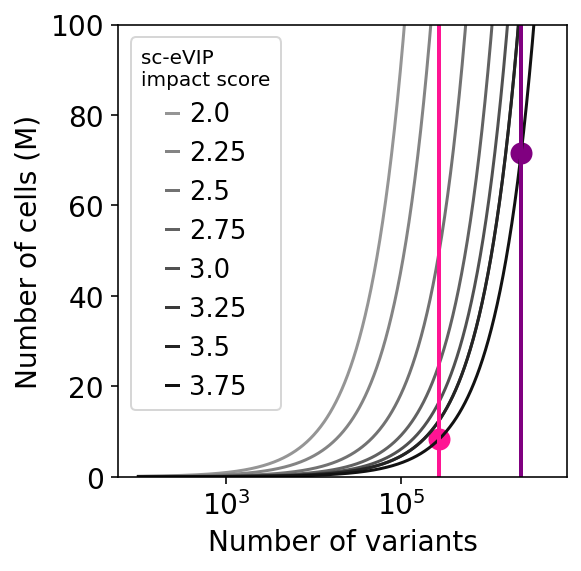

In [82]:
df=cells_per_bin_by_variant.T

import matplotlib.cm as cm
import matplotlib
norm = matplotlib.colors.Normalize(vmin=0, vmax=4)
mapper = cm.ScalarMappable(norm=norm, cmap=cm.Greys)

fig,plots=plt.subplots(1,1)
fig.set_size_inches(4,4)
for effect_size in df.columns:
    col=mapper.to_rgba(float(effect_size))
    plots.plot(np.power(10,df.index/150),df[str(effect_size)]/1000000,c=col,label=str(effect_size))
    #plots.plot(multipliers,1.0*df.loc[:,effect_size]/1000000,c=col,label=str(effect_size))
    plots.set_xscale('log')
    plots.grid(False)
    plots.set_ylim(0,100)
    #plots.set_xlim(1,4000000)
    plots.set_xlabel('Number of variants')
    plots.set_ylabel('Number of cells (M)')
    plots.legend(title='sc-eVIP \nimpact score')
    #plots.set_xlim(100,max(np.power(10,df.index/150)))
    c1='purple'
    c2='deeppink'
    plots.axvline(x=2300000,color=c1,lw=2)#,linestyle='--')
    plots.axvline(x=270000,color=c2,lw=2)#,linestyle='--')
plots.scatter([270000],[df.loc[815,str(3.75)]/1000000],color=c2,s=100)
plots.scatter([2300000],[df.loc[955,str(3.75)]/1000000],color=c1,s=100)

plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded_byNumVariants.pdf',bbox_inches = "tight") 
plt.savefig(FIGS+'/PowerAnalysis_cellsNeeded_byNumVariants.png',bbox_inches = "tight")
plt.show()